# GROUP ASSIGNMENT - STATISTICS FOR DATA SCIENCE - FALL 2019 #

### Group Members: Darwing Cara, David Kobayashi, Eric Koritko, Stefan Lazarevic, Patrick McDonnell ###

We have selected to work on a data set from ASHRAE (a technical society for heating, ventilation, and air conditioning in buildings). The dataset can be found here: https://www.kaggle.com/c/ashrae-energy-prediction

The goal of this exercise is to use the dataset to build a model that can predict energy use in a building based on that building's features (building use type, outdoor air conditions, etc).

## 1.0 - IMPORT PACKAGES ##

In [1]:
import pandas as pd
import numpy  as np
import math as math
import datetime
import time
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1.1 - DEFINE USEFUL FUNCTIONS

In [2]:
def compress_dataframe(dataframe):

    start = time.time()
    
    print('Dataframe was {:.2f} MB'.format(startingMemoryUsage))

    for column in dataframe.columns:
        columnDataType = dataframe[column].dtype
        
        if column == 'timestamp':
            dataframe[column] = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S')
        
        elif columnDataType != object:
            columnMin = dataframe[column].min()
            columnMax = dataframe[column].max()

            if str(columnDataType)[:3] == 'int':
                if columnMin > np.iinfo(np.int8).min and columnMax < np.iinfo(np.int8).max:
                    dataframe[column] = dataframe[column].astype(np.int8)
                elif columnMin > np.iinfo(np.int16).min and columnMax < np.iinfo(np.int16).max:
                    dataframe[column] = dataframe[column].astype(np.int16)
                elif columnMin > np.iinfo(np.int32).min and columnMax < np.iinfo(np.int32).max:
                    dataframe[column] = dataframe[column].astype(np.int32)
                elif columnMin > np.iinfo(np.int64).min and columnMax < np.iinfo(np.int64).max:
                    dataframe[column] = dataframe[column].astype(np.int64)  
            else:
                if columnMin > np.finfo(np.float16).min and columnMax < np.finfo(np.float16).max:
                    dataframe[column] = dataframe[column].astype(np.float16)
                elif columnMin > np.finfo(np.float32).min and columnMax < np.finfo(np.float32).max:
                    dataframe[column] = dataframe[column].astype(np.float32)
                else:
                    dataframe[column] = dataframe[column].astype(np.float64)
        else:
            dataframe[column] = dataframe[column].astype('category')

    endingingMemoryUsage = dataframe.memory_usage().sum() / 1024**2

    print('Dataframe is now: {:.2f} MB'.format(endingingMemoryUsage))
    
    print("Time to reduce dataframe size:",round((time.time()-start)/60, 2), 'minutes.')

In [3]:
# Given a building_id, a meter type, and a date range, plot the energy use

def plotData(df, building_id, meter, name, start_day, end_day):
  
    df_plt = df[(df['building_id'] == building_id) & (df['meter'] == meter)]
    df_plt = df_plt[(df_plt['timestamp'] > start_day) & (df_plt['timestamp'] < end_day)]
    
    plt.figure(figsize=(20,2))
    plt.plot(df_plt['timestamp'], df_plt['meter_reading'])
    plt.xlabel('Time')
    plt.ylabel('Meter Reading')
    plt.title(name)
    plt.show()

In [4]:
# Given a zone_id and a date range, plot the weather

def plotWeather(df, zone_id, name, start_day, end_day, parameter):

    df_plt = df[df['site_id'] == zone_id]
    df_plt = df_plt[(df_plt['timestamp'] > start_day) & (df_plt['timestamp'] < end_day)]
    
    plt.figure(figsize=(20,2))
    plt.plot(df_plt['timestamp'], df_plt[parameter])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(name)
    plt.show()

In [5]:
# Given a building_id, plot energy use (all three meters, if available) and weather data

def display_energy_use(df, building_id, start_day, end_day):

    print("Displaying data for Building", building_id, "between:", start_day, "and", end_day, '\n')
    
    print("Building's primary use:", df.loc[df['building_id'] == building_id, 'primary_use'].iloc[0])
    
    print("Building size:", df.loc[df['building_id'] == building_id, 'square_feet'].iloc[0], 'square feet')
      
    for meter_type in df[df['building_id'] == building_id].groupby('meter').meter.unique():
        if(meter_type == elec_meter):
            plotData(df, building_id, elec_meter, "Electricity Meter Data", start_day, end_day)
        if(meter_type == chw_meter):
            plotData(df, building_id, chw_meter,"Chilled Water Meter Data", start_day, end_day)
        if(meter_type == steam_meter):
            plotData(df, building_id, steam_meter, "Steam Meter Data", start_day, end_day)
        if(meter_type == hw_meter):
            plotData(df, building_id,hw_meter, "Hot Water Meter Data", start_day, end_day)            
            
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Air Temperature", start_day, end_day, 'air_temperature')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Cloud Coverage", start_day, end_day, 'cloud_coverage')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Dewpoint Temperature", start_day, end_day, 'dew_temperature')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Precipitation Depth", start_day, end_day, 'precip_depth_1_hr')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Sea Level Pressure", start_day, end_day, 'sea_level_pressure')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Wind Direction", start_day, end_day, 'wind_direction')
    plotWeather(df, df.loc[df['building_id'] == building, 'site_id'].iloc[0], "Weather Data - Wind Speed", start_day, end_day, 'wind_speed')

## 1.2 - DEFINE USEFUL CONSTANTS

In [6]:
elec_meter = 0
chw_meter = 1
steam_meter = 2
hw_meter = 3

# 2.0 - LOAD DATASET INTO MEMORY

In [7]:
start = time.time()

df = pd.read_csv(filepath_or_buffer='train.csv', sep=',', low_memory=False)

print('Time to read the CSV file into a dataframe: ',round((time.time()-start), 2), 'seconds \n')

startingMemoryUsage = df.memory_usage().sum() / 1024**2

print('Dataframe size is {:.2f} MB'.format(startingMemoryUsage))

Time to read the CSV file into a dataframe:  5.84 seconds 

Dataframe size is 616.95 MB


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [9]:
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [10]:
compress_dataframe(df)

Dataframe was 616.95 MB
Dataframe is now: 289.19 MB
Time to reduce dataframe size: 0.03 minutes.


In [11]:
start = time.time()

df_weather = pd.read_csv(filepath_or_buffer='weather_train.csv', sep=',', low_memory=False)

print('Time to read the CSV file into a dataframe: ',round((time.time()-start), 2), 'seconds \n')

startingMemoryUsage = df_weather.memory_usage().sum() / 1024**2

print('Dataframe size is {:.2f} MB'.format(startingMemoryUsage))

Time to read the CSV file into a dataframe:  0.07 seconds 

Dataframe size is 9.60 MB


In [12]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [13]:
df_weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [14]:
compress_dataframe(df_weather)

Dataframe was 9.60 MB
Dataframe is now: 3.07 MB
Time to reduce dataframe size: 0.0 minutes.


In [15]:
start = time.time()

df_building_metadata = pd.read_csv(filepath_or_buffer='building_metadata.csv', sep=',', low_memory=False)

print('Time to read the CSV file into a dataframe: ',round((time.time()-start), 2), 'seconds \n')

startingMemoryUsage = df_weather.memory_usage().sum() / 1024**2

print('Dataframe size is {:.2f} MB'.format(startingMemoryUsage))

Time to read the CSV file into a dataframe:  0.0 seconds 

Dataframe size is 3.07 MB


In [16]:
df_building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [17]:
df_building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [18]:
compress_dataframe(df_building_metadata)

Dataframe was 3.07 MB
Dataframe is now: 0.02 MB
Time to reduce dataframe size: 0.0 minutes.


# 3.0 - CLEAN THE DATASET

## 3.1 - CHECK FOR DUPLICATE ROWS

In [19]:
df[df.duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
building_id      0 non-null int16
meter            0 non-null int8
timestamp        0 non-null datetime64[ns]
meter_reading    0 non-null float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 0.0 bytes


## 3.2 - CHECK FOR NULL VALUES IN THE MAIN DATASET AND WEATHER DATASET

In [20]:
# Show how many nulls there are in the main dataset (expressed as a percentage)
print(round(df.isna().sum().sort_values(ascending=False) / len(df.index) * 100, 3))

meter_reading    0.0
timestamp        0.0
meter            0.0
building_id      0.0
dtype: float64


In [21]:
# Show how many nulls there are in the weather dataset (expressed as a percentage)
print(round(df_weather.isna().sum().sort_values(ascending=False) / len(df_weather.index) * 100, 3))

cloud_coverage        49.490
precip_depth_1_hr     35.979
sea_level_pressure     7.597
wind_direction         4.484
wind_speed             0.217
dew_temperature        0.081
air_temperature        0.039
timestamp              0.000
site_id                0.000
dtype: float64


In [22]:
# Fill nulls with linear interpolation
df_weather = df_weather.interpolate()
df_weather = df_weather.fillna(0)

# Double check how many nulls are in the feature (should be 0 now)
print(round(df_weather.isna().sum().sort_values(ascending=False) / len(df_weather.index) * 100, 3))

wind_speed            0.0
wind_direction        0.0
sea_level_pressure    0.0
precip_depth_1_hr     0.0
dew_temperature       0.0
cloud_coverage        0.0
air_temperature       0.0
timestamp             0.0
site_id               0.0
dtype: float64


In [23]:
# Show how many nulls there are in the metadata dataset (expressed as a percentage)
print(round(df_building_metadata.isna().sum().sort_values(ascending=False) / len(df_building_metadata.index) * 100, 3))

floor_count    75.500
year_built     53.416
square_feet     0.000
primary_use     0.000
building_id     0.000
site_id         0.000
dtype: float64


## 3.3 - FILTER OUT OFFICE BUILDINGS AND MERGE DATASETS

In [24]:
# count the number of different building types in the dataset
# df_building_metadata['primary_use'].value_counts()

# filter out the data that relates to office buildings
df_building_metadata = df_building_metadata[df_building_metadata['primary_use'] == 'Office']

# merge this data with the main dataframe, so that we only have meter readings for office buildings
df = df.merge(df_building_metadata, on='building_id', how='inner')

# merge weather data with the main dataframe, so that all the information is in one place
df = df.merge(df_weather, on=['site_id', 'timestamp'], how='inner')

# check dataframe
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,9,0,2016-01-01,0.0,0,Office,27000,2010.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
1,15,0,2016-01-01,0.0,0,Office,83957,1974.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
2,17,0,2016-01-01,0.0,0,Office,15250,1980.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
3,19,0,2016-01-01,0.0,0,Office,18717,2004.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
4,21,0,2016-01-01,0.0,0,Office,7043,1990.0,NaN,25.0,6.0,20.0,0.0,1019.5,0.0,0.0


## 3.4 - CHECK FOR NULL VALUES IN THE METADATA DATASET

In [25]:
print(round(df.isna().sum().sort_values(ascending=False) / len(df.index) * 100, 3))

floor_count           91.875
year_built            75.699
wind_speed             0.000
wind_direction         0.000
sea_level_pressure     0.000
precip_depth_1_hr      0.000
dew_temperature        0.000
cloud_coverage         0.000
air_temperature        0.000
square_feet            0.000
primary_use            0.000
site_id                0.000
meter_reading          0.000
timestamp              0.000
meter                  0.000
building_id            0.000
dtype: float64


In [26]:
# There's no great way to fill the floor_count and year_built columns
# Since there are a large number of nulls in the floor_count and year_built features, we will drop these columns

df = df.drop('floor_count', axis=1)
df = df.drop('year_built', axis=1)

df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,9,0,2016-01-01,0.0,0,Office,27000,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
1,15,0,2016-01-01,0.0,0,Office,83957,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
2,17,0,2016-01-01,0.0,0,Office,15250,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
3,19,0,2016-01-01,0.0,0,Office,18717,25.0,6.0,20.0,0.0,1019.5,0.0,0.0
4,21,0,2016-01-01,0.0,0,Office,7043,25.0,6.0,20.0,0.0,1019.5,0.0,0.0


## 3.5 - USE THIS SECTION TO VIEW METER DATA AND WEATHER DATA TOGETHER

Displaying data for Building 9 between: 2016-07-01 and 2016-07-02 

Building's primary use: Office
Building size: 27000 square feet


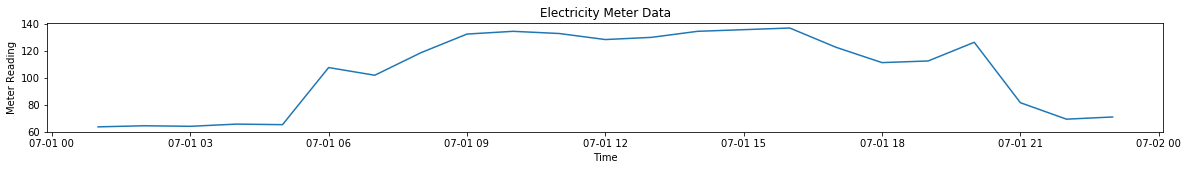

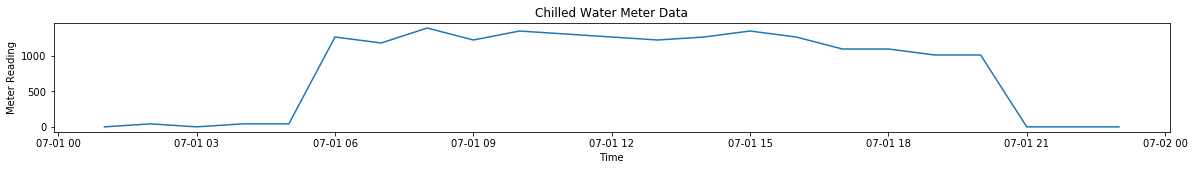

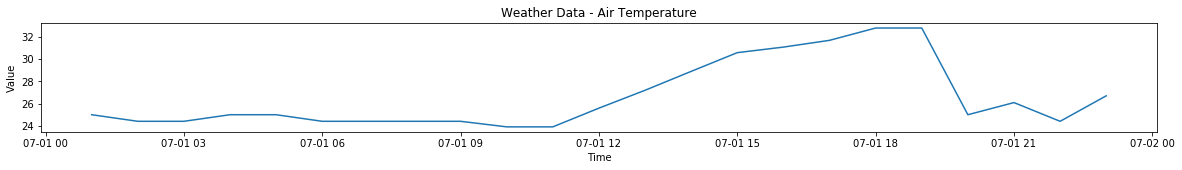

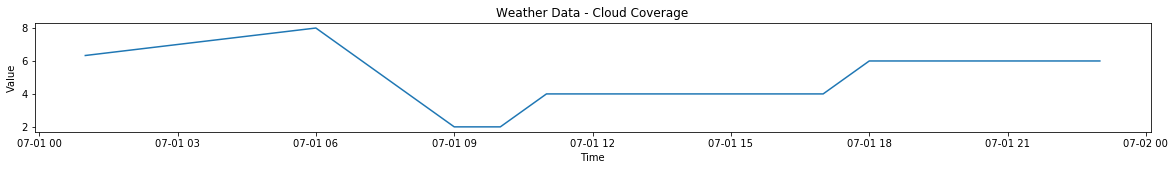

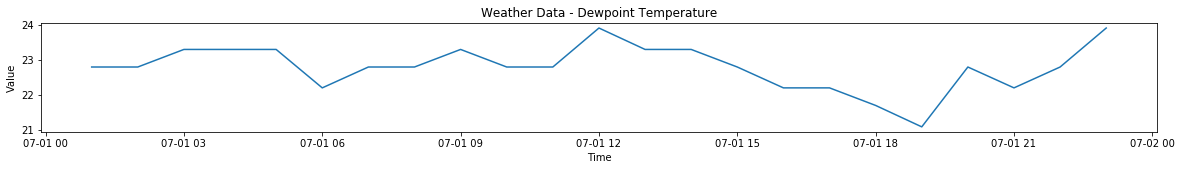

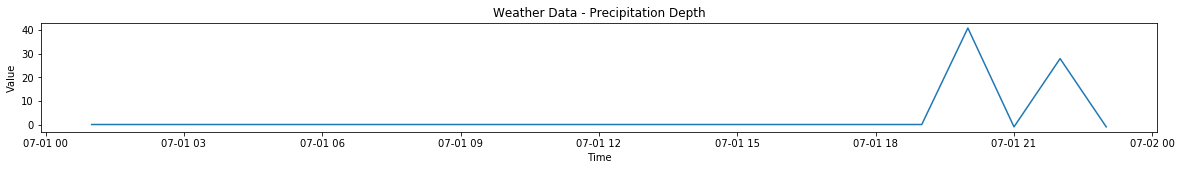

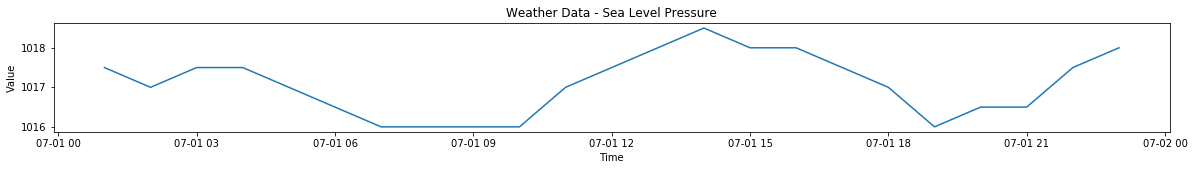

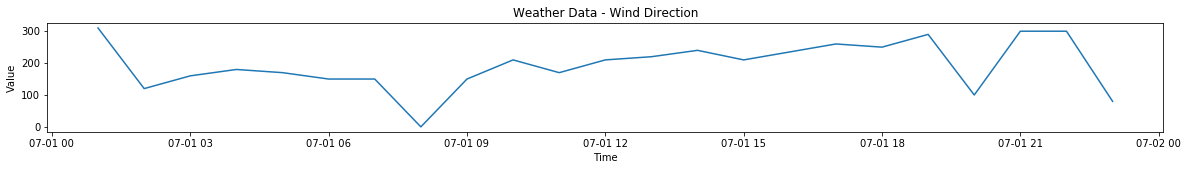

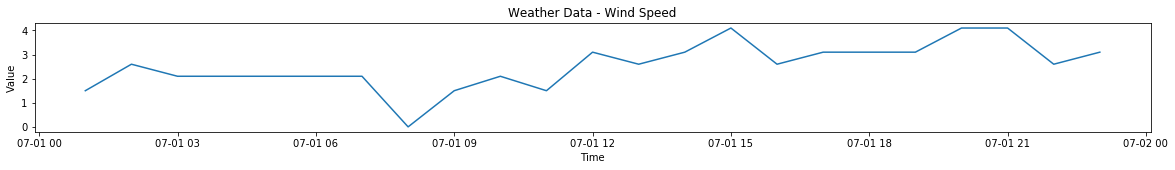

In [27]:
# Change the building_id, the start date, and the end date. This will plot everything, in increments of days

# --------------------------#
building = 9
start_day = "2016-07-01"
end_day = "2016-07-02"
# --------------------------#

if building in df['building_id'].unique():
    display_energy_use(df, building, start_day, end_day)  